In [51]:

from google.colab import drive
import os
# Mount Google Drive
#drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/LEARN/Finance/quantitative finance/Project/Project-3_index_creation')
print(os.getcwd())


/content/drive/My Drive/LEARN/Finance/quantitative finance/Project/Project-3_index_creation


In [85]:
import numpy as np
from sqlalchemy import create_engine, text
import yfinance as yf
import datetime
import matplotlib.pyplot as plt

import pandas as pd
from pandas.tseries.offsets import BMonthEnd, BDay
from scipy.stats import zscore
import warnings
warnings.filterwarnings("ignore")

# Problem Statement

The project trues to build a MSCI inspired momentum index based on (NIFTY 500) parent index.

ref : (https://www.msci.com/eqb/methodology/meth_docs/MSCI_Momentum_Indexes_Methodology_Aug2021.pdf)

# Static Data : Strategy to get NIFTY 50 momentum index from NIFTY 100 universe

## NIFTY 100 index price (Parent) [01/01/2003 - 18/02/2026]

In [53]:
'''
data = yf.download(
    "^CNX100",
    start="2003-01-01",
    end="2026-02-18",
    interval="1d",
    group_by="ticker",
    auto_adjust=False,
    threads=True
)

data.reset_index(inplace=True)
data.to_excel("nifty100_index.xlsx")
data.head()
'''

'\ndata = yf.download(\n    "^CNX100",\n    start="2003-01-01",\n    end="2026-02-18",\n    interval="1d",\n    group_by="ticker",\n    auto_adjust=False,\n    threads=True\n)\n\ndata.reset_index(inplace=True)\ndata.to_excel("nifty100_index.xlsx")\ndata.head()\n'

URGENT - Num of NaN/NaT/None values 0


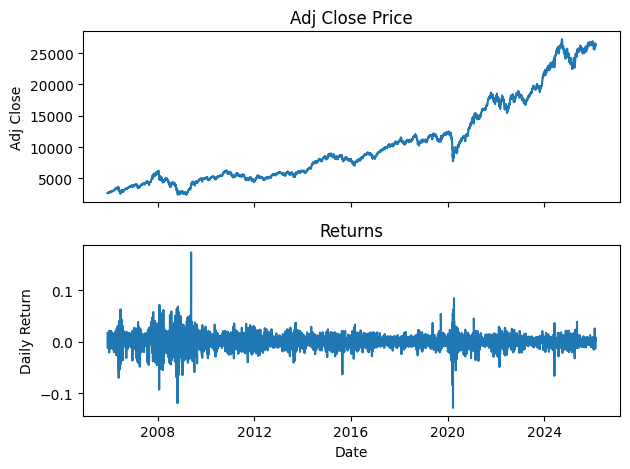

,Adj Close,return
Date,,
2005-12-01,2649.750000,0.017139
2005-12-02,2652.300049,0.000962
2005-12-05,2619.699951,-0.012291
2005-12-06,2618.600098,-0.000420
2005-12-07,2646.350098,0.010597


In [54]:
df_index = pd.read_excel("nifty100_index.xlsx" , skiprows=[0,2])
df_index.rename(columns={'Unnamed: 1': 'Date'}, inplace=True)
df_index.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume', 'Price'], inplace=True)
print ('URGENT - Num of NaN/NaT/None values', df_index.isna().sum().sum())

df_index = df_index.set_index("Date")
df_index = df_index.sort_index()
#df_index = df_index.ffill()
#print("Remaining NaNs:", df_index.isna().sum().sum())

df_index["return"] = df_index["Adj Close"].pct_change()
df_index.dropna(inplace=True)

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True)

# --- Adj Close ---
axes[0].plot(df_index["Adj Close"])
axes[0].set_ylabel("Adj Close")
axes[0].set_title("Adj Close Price")

# --- Returns ---
axes[1].plot(df_index["return"])
axes[1].set_ylabel("Daily Return")
axes[1].set_xlabel("Date")
axes[1].set_title("Returns")

plt.tight_layout()
plt.show()

df_index.head()

## NIFTY 100 constituets info [01/01/2003 - 18/02/2026]

In [55]:
'''
import requests
from io import StringIO

url = "https://www.niftyindices.com/IndexConstituent/ind_nifty100list.csv"

# Some NSE endpoints require headers to succeed
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)",
    "Accept-Language": "en-US,en;q=0.9",
    "Referer": "https://www.nseindia.com/market-data/live-equity-market"
}

resp = requests.get(url, headers=headers)
df_list = pd.read_csv(StringIO(resp.text))

symbols = df_list["Symbol"].tolist()
yf_symbols = [s + ".NS" for s in symbols]

print(yf_symbols)
'''

yf_symbols = ['ABB.NS', 'ADANIENSOL.NS', 'ADANIENT.NS', 'ADANIGREEN.NS', 'ADANIPORTS.NS', 'ADANIPOWER.NS', 'AMBUJACEM.NS', 'APOLLOHOSP.NS', 'ASIANPAINT.NS', 'DMART.NS', 'AXISBANK.NS', 'BAJAJ-AUTO.NS', 'BAJFINANCE.NS', 'BAJAJFINSV.NS', 'BAJAJHLDNG.NS', 'BAJAJHFL.NS', 'BANKBARODA.NS', 'BEL.NS', 'BPCL.NS', 'BHARTIARTL.NS', 'BOSCHLTD.NS', 'BRITANNIA.NS', 'CGPOWER.NS', 'CANBK.NS', 'CHOLAFIN.NS', 'CIPLA.NS', 'COALINDIA.NS', 'DLF.NS', 'DIVISLAB.NS', 'DRREDDY.NS', 'EICHERMOT.NS', 'ETERNAL.NS', 'GAIL.NS', 'GODREJCP.NS', 'GRASIM.NS', 'HCLTECH.NS', 'HDFCBANK.NS', 'HDFCLIFE.NS', 'HAVELLS.NS', 'HINDALCO.NS', 'HAL.NS', 'HINDUNILVR.NS', 'HINDZINC.NS', 'HYUNDAI.NS', 'ICICIBANK.NS', 'ICICIGI.NS', 'ITC.NS', 'INDHOTEL.NS', 'IOC.NS', 'IRFC.NS', 'NAUKRI.NS', 'INFY.NS', 'INDIGO.NS', 'JSWENERGY.NS', 'JSWSTEEL.NS', 'JINDALSTEL.NS', 'JIOFIN.NS', 'KOTAKBANK.NS', 'KWIL.NS', 'LTIM.NS', 'LT.NS', 'LICI.NS', 'LODHA.NS', 'M&M.NS', 'MARUTI.NS', 'MAXHEALTH.NS', 'MAZDOCK.NS', 'NTPC.NS', 'NESTLEIND.NS', 'ONGC.NS', 'PIDILITIND.NS', 'PFC.NS', 'POWERGRID.NS', 'PNB.NS', 'RECLTD.NS', 'RELIANCE.NS', 'SBILIFE.NS', 'MOTHERSON.NS', 'SHREECEM.NS', 'SHRIRAMFIN.NS', 'ENRIN.NS', 'SIEMENS.NS', 'SOLARINDS.NS', 'SBIN.NS', 'SUNPHARMA.NS', 'TVSMOTOR.NS', 'TCS.NS', 'TATACONSUM.NS', 'TMPV.NS', 'TATAPOWER.NS', 'TATASTEEL.NS', 'TECHM.NS', 'TITAN.NS', 'TORNTPHARM.NS', 'TRENT.NS', 'ULTRACEMCO.NS', 'UNITDSPR.NS', 'VBL.NS', 'VEDL.NS', 'WIPRO.NS', 'ZYDUSLIFE.NS']

In [56]:
'''
data = yf.download(
    yf_symbols,
    start="2003-01-01",
    end="2026-01-18",
    interval="1d",
    group_by="ticker",
    auto_adjust=False,
    threads=True
)

df_wide = pd.DataFrame({sym: data[sym]["Adj Close"] for sym in yf_symbols})
df_wide.to_excel("nifty100_equityprice.xlsx")
'''

'\ndata = yf.download(\n    yf_symbols,\n    start="2003-01-01",\n    end="2026-01-18",\n    interval="1d",\n    group_by="ticker",\n    auto_adjust=False,\n    threads=True\n)\n\ndf_wide = pd.DataFrame({sym: data[sym]["Adj Close"] for sym in yf_symbols})\ndf_wide.to_excel("nifty100_equityprice.xlsx")\n'

In [57]:
df_equityprice = pd.read_excel("nifty100_equityprice.xlsx")
print ('URGENT - Num of NaN/NaT/None values', df_equityprice.isna().sum().sum())
df_equityprice = df_equityprice.set_index("Date")
df_equityprice.head()

URGENT - Num of NaN/NaT/None values 117867


,ABB.NS,ADANIENSOL.NS,ADANIENT.NS,ADANIGREEN.NS,ADANIPORTS.NS,ADANIPOWER.NS,AMBUJACEM.NS,APOLLOHOSP.NS,ASIANPAINT.NS,DMART.NS,...,TECHM.NS,TITAN.NS,TORNTPHARM.NS,TRENT.NS,ULTRACEMCO.NS,UNITDSPR.NS,VBL.NS,VEDL.NS,WIPRO.NS,ZYDUSLIFE.NS
Date,,,,,,,,,,,,,,,,,,,,,
2003-01-01,6.812234,NaN,0.046527,NaN,NaN,NaN,13.986336,44.802578,16.160059,NaN,...,NaN,3.377123,8.986462,11.459856,283.733551,NaN,NaN,0.455858,23.783369,11.854362
2003-01-02,6.835398,NaN,0.046656,NaN,NaN,NaN,14.267457,45.754929,16.253986,NaN,...,NaN,3.304945,8.979711,11.943260,283.824402,NaN,NaN,0.450295,23.539156,12.080729
2003-01-03,6.918507,NaN,0.046688,NaN,NaN,NaN,14.050225,46.051212,16.281576,NaN,...,NaN,3.230974,8.902080,11.856966,280.554657,NaN,NaN,0.443095,23.475414,12.356250
2003-01-06,7.156935,NaN,0.046366,NaN,NaN,NaN,13.884101,46.474480,16.358362,NaN,...,NaN,3.206764,9.221037,12.597064,280.554657,NaN,NaN,0.440150,23.875044,12.301192
2003-01-07,7.159662,NaN,0.046462,NaN,NaN,NaN,13.852157,47.088215,16.447817,NaN,...,NaN,3.171797,9.086027,11.808697,281.462891,NaN,NaN,0.442441,23.656601,12.035485


In [58]:
nan_matrix = pd.DataFrame({
    "num_nan": df_equityprice.isna().sum(),
    "first_non_nan_date": df_equityprice.apply(lambda x: x.first_valid_index())
})

# Sort by data availability (earliest first)
nan_matrix = nan_matrix.sort_values("first_non_nan_date")

nan_matrix_clean = nan_matrix.dropna(subset=["first_non_nan_date"])
yf_symbols = nan_matrix_clean.index.tolist()

print('no of constituents in parent universe', len(yf_symbols_clean))

nan_matrix_clean

no of constituents in parent universe 100


,num_nan,first_non_nan_date
ABB.NS,1,2003-01-01
ONGC.NS,4,2003-01-01
NESTLEIND.NS,1,2003-01-01
M&M.NS,3,2003-01-01
LT.NS,1,2003-01-01
...,...,...
UNITDSPR.NS,5315,2024-05-30
BAJAJHFL.NS,5385,2024-09-16
HYUNDAI.NS,5410,2024-10-22
ENRIN.NS,5575,2025-06-19


### Approximate historical market cap

In [59]:
'''
def get_current_shares(symbol):
    try:
        t = yf.Ticker(symbol)
        return t.info.get("sharesOutstanding", np.nan)
    except Exception:
        return np.nan


shares_outstanding = {sym: get_current_shares(sym) for sym in yf_symbols}

df_shares = pd.Series(shares_outstanding, name="shares_outstanding")
df_shares.head()

iwf_matrix = np.random.uniform(0.10, 1.00, size=df_equityprice.shape)
df_ff_mcap = df_equityprice * df_shares * iwf_matrix

df_ff_mcap.to_excel("nifty100_equitymcap.xlsx")
'''

'\ndef get_current_shares(symbol):\n    try:\n        t = yf.Ticker(symbol)\n        return t.info.get("sharesOutstanding", np.nan)\n    except Exception:\n        return np.nan\n\n\nshares_outstanding = {sym: get_current_shares(sym) for sym in yf_symbols}\n\ndf_shares = pd.Series(shares_outstanding, name="shares_outstanding")\ndf_shares.head()\n\niwf_matrix = np.random.uniform(0.10, 1.00, size=df_equityprice.shape)\ndf_ff_mcap = df_equityprice * df_shares * iwf_matrix\n\ndf_ff_mcap.to_excel("nifty100_equitymcap.xlsx")\n'

In [60]:
df_equitymcap = pd.read_excel(
    "nifty100_equitymcap.xlsx",
    index_col=0,        # Date index
    parse_dates=True
)
df_equitymcap.head()

,ABB.NS,ADANIENSOL.NS,ADANIENT.NS,ADANIGREEN.NS,ADANIPORTS.NS,ADANIPOWER.NS,AMBUJACEM.NS,APOLLOHOSP.NS,ASIANPAINT.NS,AXISBANK.NS,...,TMPV.NS,TORNTPHARM.NS,TRENT.NS,TVSMOTOR.NS,ULTRACEMCO.NS,UNITDSPR.NS,VBL.NS,VEDL.NS,WIPRO.NS,ZYDUSLIFE.NS
Date,,,,,,,,,,,,,,,,,,,,,
2003-01-01,1.265689e+09,NaN,1.783175e+07,NaN,NaN,NaN,2.685686e+10,6.410221e+09,3.876617e+09,3.005360e+09,...,NaN,7.461137e+08,5.488873e+08,3.932033e+09,5.060433e+10,NaN,NaN,1.078003e+09,8.956238e+10,7.333258e+09
2003-01-02,4.249756e+08,NaN,1.565485e+07,NaN,NaN,NaN,4.233987e+09,1.290639e+09,1.008323e+10,1.161533e+10,...,NaN,4.031308e+08,2.792522e+09,3.857412e+09,2.375705e+10,NaN,NaN,1.693404e+09,1.849596e+11,8.342292e+09
2003-01-03,1.196316e+09,NaN,4.410156e+07,NaN,NaN,NaN,2.552191e+10,6.077372e+09,1.305110e+10,1.732616e+10,...,NaN,8.846959e+08,3.892759e+09,8.814264e+09,7.820996e+10,NaN,NaN,8.534450e+08,4.930602e+10,1.137235e+10
2003-01-06,1.407442e+09,NaN,1.594980e+07,NaN,NaN,NaN,1.058201e+10,7.008191e+08,9.154529e+09,1.070679e+10,...,NaN,3.003810e+09,8.762631e+08,8.523291e+09,2.864368e+10,NaN,NaN,3.752289e+08,3.373133e+10,1.091265e+10
2003-01-07,5.924717e+08,NaN,1.107976e+07,NaN,NaN,NaN,3.083093e+10,4.298917e+09,2.240015e+09,1.637989e+10,...,NaN,1.286078e+09,2.507948e+09,5.339479e+09,3.821928e+10,NaN,NaN,1.721093e+09,9.834708e+10,5.551247e+09


## Initialize code

In [136]:
class BuildMomentumIndexStatic:

    def __init__(self, yf_symbols, df_index, df_equityprince, df_equitymcap, date_today, start = False, last_index_value = None, last_index_weight = None, last_parent_weight = None):

        self.trading_days = 250
        self.rfr = 6.5
        self.rfr_daily = (self.rfr / 100) / self.trading_days


        self.date_today = pd.Timestamp(date_today)

        self.yf_symbols = yf_symbols
        self.df_index = df_index
        self.df_equityprice = df_equityprice
        self.df_equitymcap = df_equitymcap

        self.adhoc_active = False
        self.start = start
        if self.start:
            self.index_value = None
            self.index_weight = None
            self.parent_weight = None

            self.mandatory_rebalancing()
        else:
            self.index_value = last_index_value
            self.index_weight = last_index_weight
            self.parent_weight = last_parent_weight

            if self.date_today == self.date_today + BMonthEnd(0) and self.date_today.month in [6, 12]:
                print ("Mandatory Rebalancing on ", self.date_today)
                self.mandatory_rebalancing()

            elif self.date_today == (self.date_today + BMonthEnd(0) - BDay(9)):
                 if self.adhoc_trigger():
                    print ("Adhoc Rebalancing on ", self.date_today)
                    self.adhoc_active = True
                    self.mandatory_rebalancing()

            self.no_rebalancing()

    # ------------------------------------------------------------------
    # MANDATORY REBALANCING
    # ------------------------------------------------------------------

    def mandatory_rebalancing(self):

        prices = self.df_equityprice.loc[:self.date_today].copy()

        # -----------------------------
        # Risk-free rate
        # -----------------------------
        rf = self.rfr_daily

        # -----------------------------
        # Lookback dates
        # -----------------------------
        t1  = self.date_today - BMonthEnd(1)
        t7  = self.date_today - BMonthEnd(7)
        t13 = self.date_today - BMonthEnd(13)

        # Align to available trading dates
        P_t1  = prices.loc[:t1].iloc[-1]
        P_t7  = prices.loc[:t7].iloc[-1]
        P_t13 = prices.loc[:t13].iloc[-1]

        # -----------------------------
        # Momentum
        # -----------------------------
        mom_6m  = (P_t1 / P_t7 - 1) - self.rfr * (0.5 / 100)
        mom_12m = (P_t1 / P_t13 - 1) - self.rfr * (1 / 100)

        # -----------------------------
        # Volatility (weekly)
        # -----------------------------
        weekly_prices = prices.resample("W-FRI").last()
        weekly_returns = weekly_prices.pct_change()

        sigma = weekly_returns.std() * np.sqrt(52)

        valid = (sigma > 0) & np.isfinite(sigma)

        # -----------------------------
        # Risk-adjusted momentum
        # -----------------------------
        ra_6m  = mom_6m / sigma
        ra_12m = mom_12m / sigma

        df = pd.DataFrame({
            "ra_6m": ra_6m,
            "ra_12m": ra_12m
        }).loc[valid]

        # -----------------------------
        # Z-scores
        # -----------------------------
        df["z_6m"]  = zscore(df["ra_6m"], nan_policy="omit")
        df["z_12m"] = zscore(df["ra_12m"], nan_policy="omit")

        # -----------------------------
        # Combined score
        # -----------------------------
        if self.adhoc_active:
            df["C"] = df["z_6m"]
        else:
            df["C"] = np.where(
                df["z_12m"].isna(),
                df["z_6m"],
                0.5 * df["z_6m"] + 0.5 * df["z_12m"]
            )

        # -----------------------------
        # Final Z + winsorisation
        # -----------------------------
        df["Z"] = zscore(df["C"], nan_policy="omit").clip(-3, 3)

        # -----------------------------
        # Momentum score transform
        # -----------------------------
        df["MomentumScore"] = np.where(
            df["Z"] >= 0,
            1 + df["Z"],
            1 / (1 - df["Z"])
        )

        # -----------------------------
        # MCAP + parent weights
        # -----------------------------
        mcap_today = self.df_equitymcap.loc[:self.date_today].iloc[-1]
        parent_cap = mcap_today.sum()
        parent_weight = mcap_today / parent_cap

        df["mcap"] = mcap_today
        df["parent_weight"] = parent_weight

        # -----------------------------
        # Ranking & selection
        # -----------------------------
        df = df.sort_values(
            ["MomentumScore", "parent_weight"],
            ascending=[False, False]
        )

        N = 50
        df = df.iloc[:N]

        # -----------------------------
        # Weighting
        # -----------------------------
        df["MomentumWeight"] = (
            df["MomentumScore"] * df["parent_weight"] * df["mcap"]
        )

        df["FinalWeight"] = df["MomentumWeight"] / df["MomentumWeight"].sum()

        df["InclusionFactor"] = df["FinalWeight"] / df["parent_weight"]

        # -----------------------------
        # Issuer cap
        # -----------------------------
        max_parent_weight = df["parent_weight"].max()
        issuer_cap = 0.05 if max_parent_weight <= 0.10 else max_parent_weight

        df["FinalWeightCapped"] = df["FinalWeight"].clip(upper=issuer_cap)
        df["FinalWeightCapped"] /= df["FinalWeightCapped"].sum()

        # -----------------------------
        # Store
        # -----------------------------
        self.index_weight = df["FinalWeightCapped"].copy()
        self.parent_weight = df["parent_weight"].copy()


    # ------------------------------------------------------------------
    # Adhoc rebalancing
    # ------------------------------------------------------------------
    def adhoc_trigger(self):
        index_data = self.df_index.loc[:self.date_today]
        index_returns = index_data["return"]

        # Current volatility
        T9 = self.date_today - BDay(9)

        prev_month_end = (T9 - BMonthEnd(1))
        start_date = prev_month_end - pd.DateOffset(months=3)
        window = index_returns.loc[start_date:prev_month_end]

        Vt = np.sqrt(self.trading_days) * window.std()

        # Previous month's T-9
        prev_T9 = T9 - pd.DateOffset(months=1)

        prev_month_end = (prev_T9 - BMonthEnd(1))
        start_date = prev_month_end - pd.DateOffset(months=3)
        window = index_returns.loc[start_date:prev_month_end]
        Vt_1 = np.sqrt(250) * window.std()

        if not np.isfinite(Vt) or not np.isfinite(Vt_1):
            return False

        delta = (Vt / Vt_1) - 1

        # Reference index threshold (95th percentile of historical deltas)
        reference_index_returns = self.df_index["return"]
        ref_vol = (reference_index_returns.rolling(int(self.trading_days/12)).std().dropna() * np.sqrt(self.trading_days))
        ref_delta = ref_vol.pct_change().dropna()
        threshold = np.percentile(ref_delta, 95)

        return delta > threshold

    # ------------------------------------------------------------------
    # No rebalancing
    # ------------------------------------------------------------------
    def no_rebalancing(self):

        # Get required dates
        today = self.date_today
        prev_day = today - BDay(1)

        # Prices
        Pt = self.df_equityprice.loc[:today].iloc[-1]
        Pt_1 = self.df_equityprice.loc[:prev_day].iloc[-1]

        # Ensure alignment
        Pt, Pt_1 = Pt.align(Pt_1, join="inner")

        # Index weights (Series indexed by Symbol)
        weights = pd.Series(self.index_weight)

        # Align weights with prices
        weights = weights.reindex(Pt.index)

        # Daily index return
        weighted_return = (weights * (Pt / Pt_1)).sum()

        # Update index value
        self.index_value *= weighted_return

    # ------------------------------------------------------------------
    # RETURN
    # ------------------------------------------------------------------
    def get_data(self):
        return self.index_value, self.index_weight, self.parent_weight


In [151]:
import statsmodels.api as sm
class IndexPerformanceAnalytics:
    """
    Performance analytics for two indices with daily 'Adj Close' prices
    """

    def __init__(self, df_benchmark, df_strategy, trading_days=250, rfr=6.5):
        """
        Parameters
        ----------
        df_benchmark : DataFrame
            DatetimeIndex, column 'Adj Close'
        df_strategy : DataFrame
            DatetimeIndex, column 'Adj Close'
        trading_days : int
            Annualisation factor (252 for daily data)
        rfr : float
            Annual risk-free rate in percent (e.g. 6.5)
        """

        self.trading_days = trading_days
        self.rfr = rfr

        # Convert annual % RFR to daily decimal
        self.rfr_daily = (self.rfr / 100) / self.trading_days

        self.df = pd.concat(
            [
                df_benchmark["Adj Close"].rename("Benchmark"),
                df_strategy["Adj Close"].rename("Strategy"),
            ],
            axis=1
        ).dropna()

        # Daily returns
        self.returns = self.df.pct_change().dropna()

    # -------------------------------------------------
    # RETURNS
    # -------------------------------------------------
    def daily_returns(self):
        return self.returns

    def cagr(self):
        def _cagr(series):
            n_years = (series.index[-1] - series.index[0]).days / 365.25
            return (series.iloc[-1] / series.iloc[0]) ** (1 / n_years) - 1

        return self.df.apply(_cagr)

    def daily_returns(self):
        return self.returns.std()

    def annualized_returns(self):
        return self.daily_returns() * np.sqrt(self.trading_days)

    # -------------------------------------------------
    # VOLATILITY
    # -------------------------------------------------
    def daily_volatility(self):
        return self.returns.std()

    def annual_volatility(self):
        return self.daily_volatility() * np.sqrt(self.trading_days)

    # -------------------------------------------------
    # CORRELATION
    # -------------------------------------------------
    def correlation(self):
        return self.returns["Strategy"].corr(self.returns["Benchmark"])

    # -------------------------------------------------
    # CAPM
    # -------------------------------------------------
    def capm_beta(self):
        cov = self.returns.cov()
        beta = cov.loc["Strategy", "Benchmark"] / cov.loc["Benchmark", "Benchmark"]
        return beta

    def capm_regression(self):
        """
        (R_strategy - Rf) = alpha + beta * (R_benchmark - Rf)
        """

        excess_strategy = self.returns["Strategy"] - self.rfr_daily
        excess_benchmark = self.returns["Benchmark"] - self.rfr_daily

        X = sm.add_constant(excess_benchmark)
        model = sm.OLS(excess_strategy, X).fit()

        alpha_daily = model.params["const"]
        beta = model.params["Benchmark"]

        # Annualise alpha
        alpha_annual = alpha_daily * self.trading_days

        return beta, alpha_annual

    # -------------------------------------------------
    # SHARPE RATIO
    # -------------------------------------------------
    def sharpe_ratio(self):
        """
        Annualised Sharpe Ratio using init RFR and trading days
        """

        excess_returns = self.returns["Strategy"] - self.rfr_daily

        sharpe = (
            np.sqrt(self.trading_days)
            * excess_returns.mean()
            / excess_returns.std(ddof=1)
        )

        return sharpe

    # -------------------------------------------------
    # TRACKING ERROR
    # -------------------------------------------------
    def tracking_error(self):
        """
        Annualized Tracking Error (%) of Strategy vs Benchmark

        TE = StdDev(Strategy - Benchmark) * sqrt(trading_days)
        Returns as percentage
        """
        active_returns = self.returns["Strategy"] - self.returns["Benchmark"]
        te_annual = active_returns.std(ddof=1) * np.sqrt(self.trading_days) * 100  # in %
        return te_annual


    # -------------------------------------------------
    # INFORMATION RATIO
    # -------------------------------------------------
    def information_ratio(self):
        """
        Annualized Information Ratio of Strategy vs Benchmark

        IR = Mean(Strategy - Benchmark) / StdDev(Strategy - Benchmark) * sqrt(trading_days)
        """
        active_returns = self.returns["Strategy"] - self.returns["Benchmark"]
        ir_annual = (active_returns.mean() / active_returns.std(ddof=1)) * np.sqrt(self.trading_days)
        return ir_annual


    # -------------------------------------------------
    # PLOTTING
    # -------------------------------------------------
    def plot_levels(self, normalised=True):

        if normalised:
            df_plot = self.df / self.df.iloc[0] * 100
            title = "Index Performance (Normalised)"
        else:
            df_plot = self.df
            title = "Index Levels"

        plt.figure(figsize=(12, 6))
        plt.plot(df_plot.index, df_plot["Benchmark"], label="Benchmark")
        plt.plot(df_plot.index, df_plot["Strategy"], label="Strategy")
        plt.legend()
        plt.grid(True)
        plt.title(title)
        plt.show()

    # -------------------------------------------------
    # SUMMARY
    # -------------------------------------------------
    def summary(self):

        beta_reg, alpha_reg = self.capm_regression()

        summary = pd.DataFrame({
            "~10 YCAGR (%)": self.cagr()*100,
            "Annual Return (%)": self.annualized_returns()*100,
            "Annual Vol (%)": self.annual_volatility()*100,
            "Correlation": [
                np.nan, self.correlation()
            ],
            "Sharpe Ratio": [
                np.nan, self.sharpe_ratio()
            ],
            "Beta (OLS)": [
                np.nan, beta_reg
            ],
            "Alpha (OLS, % annual)": [
                np.nan, alpha_reg
            ],
            "TE (% annual)": [
                np.nan, self.tracking_error()
            ],
            "IR (annual)": [
                np.nan, self.information_ratio()
            ]
        }, index=["Benchmark", "Strategy"])

        return summary


# FINAL RUN

In [138]:
start_date = start_date = pd.Timestamp('2016-01-01')
start_value = 8118.15

benchmark100 = df_index["Adj Close"].loc[start_date:].to_frame(name="Adj Close")
momentum50 = pd.DataFrame(index=benchmark100.index, columns=["Adj Close"], dtype=float)
benchmark100.head()

,Adj Close
Date,
2016-01-01,8118.149902
2016-01-04,7957.899902
2016-01-05,7959.850098
2016-01-06,7918.750000
2016-01-07,7731.649902


In [139]:
BMI_init = BuildMomentumIndexStatic(yf_symbols, df_index, df_equityprice, df_equitymcap, start_date, start = True)
BMI_init.index_value = start_value
present_index_value, present_index_weight, present_parent_weight = BMI_init.get_data()
present_index_value = start_value

momentum50.loc[start_date, "Adj Close"] = present_index_value

# Use df_index calendar
index_calendar = benchmark100.index

for dt in index_calendar:

    BMI_dt = BuildMomentumIndexStatic(
        yf_symbols,
        df_index,
        df_equityprice,
        df_equitymcap,
        dt,
        start=False,
        last_index_value=present_index_value,
        last_index_weight=present_index_weight,
        last_parent_weight=present_parent_weight
    )

    present_index_value, present_index_weight, present_parent_weight = BMI_dt.get_data()

    momentum50.loc[dt, "Adj Close"] = present_index_value

momentum50.tail()

Adhoc Rebalancing on  2016-02-16 00:00:00
Adhoc Rebalancing on  2016-03-18 00:00:00
Adhoc Rebalancing on  2016-04-18 00:00:00
Mandatory Rebalancing on  2016-06-30 00:00:00
Adhoc Rebalancing on  2016-12-19 00:00:00
Mandatory Rebalancing on  2016-12-30 00:00:00
Mandatory Rebalancing on  2017-06-30 00:00:00
Adhoc Rebalancing on  2017-09-18 00:00:00
Adhoc Rebalancing on  2017-10-18 00:00:00
Mandatory Rebalancing on  2017-12-29 00:00:00
Adhoc Rebalancing on  2018-03-19 00:00:00
Mandatory Rebalancing on  2018-06-29 00:00:00
Adhoc Rebalancing on  2018-11-19 00:00:00
Mandatory Rebalancing on  2018-12-31 00:00:00
Adhoc Rebalancing on  2019-06-17 00:00:00
Mandatory Rebalancing on  2019-06-28 00:00:00
Adhoc Rebalancing on  2019-10-18 00:00:00
Mandatory Rebalancing on  2019-12-31 00:00:00
Adhoc Rebalancing on  2020-03-18 00:00:00
Adhoc Rebalancing on  2020-04-17 00:00:00
Adhoc Rebalancing on  2020-05-18 00:00:00
Mandatory Rebalancing on  2020-06-30 00:00:00
Mandatory Rebalancing on  2020-12-31 00:

,Adj Close
Date,
2026-02-11,32244.230664
2026-02-12,32244.230664
2026-02-13,32244.230664
2026-02-16,32244.230664
2026-02-17,32244.230664


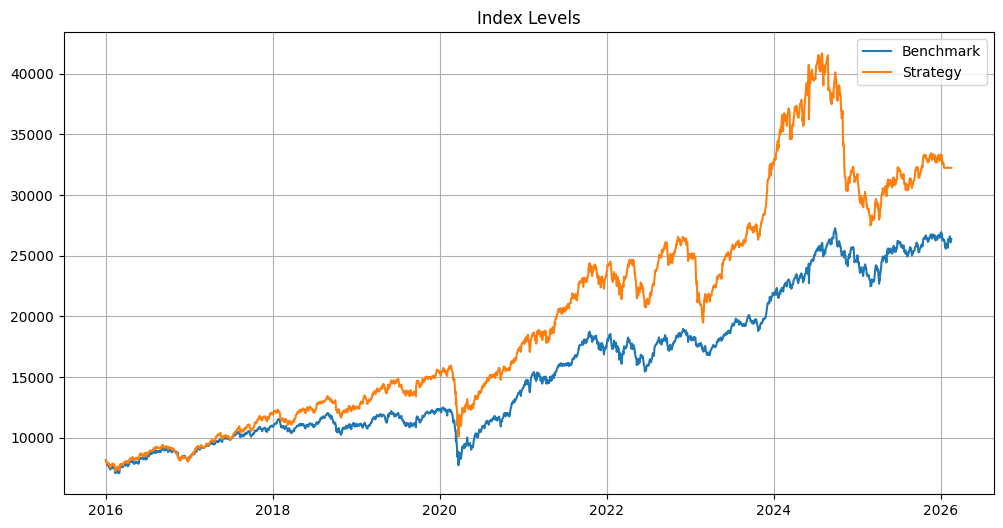

Annualized summary of 10Y


,~10 YCAGR (%),Annual Return (%),Annual Vol (%),Correlation,Sharpe Ratio,Beta (OLS),"Alpha (OLS, % annual)",TE (% annual),IR (annual)
Benchmark,12.335428,16.10030,16.10030,NaN,NaN,NaN,NaN,NaN,NaN
Strategy,14.573537,18.16615,18.16615,0.888648,0.495085,1.002672,0.02346,8.330921,0.283733


In [152]:
analytics = IndexPerformanceAnalytics(df_benchmark=benchmark100, df_strategy=momentum50)
analytics.plot_levels(normalised=False)
print ("Annualized summary of 10Y")
analytics.summary()

## WIP Dynamic Data : Strategy

In [144]:
class BuildMomentumIndex:

    def __init__(self, date_today, start = False, last_index_value = None, last_index_weight = None, last_parent_weight = None):
        self.date_today = pd.Timestamp(date_today)

        self.yf_symbols = None
        self.parent_index()

        self.adhoc_active = False
        self.start = start
        if self.start:
            self.index_value = 1000
            self.index_weight = None
            self.parent_weight = None

            self.mandatory_rebalancing()
        else:
            self.index_value = last_index_value
            self.index_weight = last_index_weight
            self.parent_weight = last_parent_weight

            if self.date_today == self.date_today + BMonthEnd(0) and self.date_today.month in [6, 12]:
                print ("Mandatory Rebalancing on ", self.date_today)
                self.mandatory_rebalancing()

            elif self.date_today == (self.date_today + BMonthEnd(0) - BDay(9)):
                 if self.adhoc_trigger():
                    print ("Adhoc Rebalancing on ", self.date_today, "  but not running it now")
                    self.adhoc_active = True
                    #self.mandatory_rebalancing()

            self.no_rebalancing()

    # ------------------------------------------------------------------
    # Parent index list (could be improvised by having the time series nifty500 constituent list)
    # ------------------------------------------------------------------
    def parent_index(self):
        '''
        import requests
        from io import StringIO

        url = "https://www.niftyindices.com/IndexConstituent/ind_nifty500list.csv"

        # Some NSE endpoints require headers to succeed
        headers = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)",
            "Accept-Language": "en-US,en;q=0.9",
            "Referer": "https://www.nseindia.com/market-data/live-equity-market"
        }

        resp = requests.get(url, headers=headers)
        df_list = pd.read_csv(StringIO(resp.text))

        symbols = df_list["Symbol"].tolist()
        yf_symbols = [s + ".NS" for s in symbols]
        '''

        #yf_symbols = ['ADANIENT.NS', 'ADANIPORTS.NS', 'APOLLOHOSP.NS', 'ASIANPAINT.NS', 'AXISBANK.NS', 'BAJAJ-AUTO.NS', 'BAJFINANCE.NS', 'BAJAJFINSV.NS', 'BEL.NS', 'BHARTIARTL.NS', 'CIPLA.NS', 'COALINDIA.NS', 'DRREDDY.NS', 'DUMMYHDLVR.NS', 'EICHERMOT.NS', 'ETERNAL.NS', 'GRASIM.NS', 'HCLTECH.NS', 'HDFCBANK.NS', 'HDFCLIFE.NS', 'HINDALCO.NS', 'HINDUNILVR.NS', 'ICICIBANK.NS', 'ITC.NS', 'INFY.NS', 'INDIGO.NS', 'JSWSTEEL.NS', 'JIOFIN.NS', 'KOTAKBANK.NS', 'LT.NS', 'M&M.NS', 'MARUTI.NS', 'MAXHEALTH.NS', 'NTPC.NS', 'NESTLEIND.NS', 'ONGC.NS', 'POWERGRID.NS', 'RELIANCE.NS', 'SBILIFE.NS', 'SHRIRAMFIN.NS', 'SBIN.NS', 'SUNPHARMA.NS', 'TCS.NS', 'TATACONSUM.NS', 'TMPV.NS', 'TATASTEEL.NS', 'TECHM.NS', 'TITAN.NS', 'TRENT.NS', 'ULTRACEMCO.NS', 'WIPRO.NS']
        yf_symbols = ['360ONE.NS', '3MINDIA.NS', 'ABB.NS', 'ACC.NS', 'ACMESOLAR.NS', 'AIAENG.NS', 'APLAPOLLO.NS', 'AUBANK.NS', 'AWL.NS', 'AADHARHFC.NS', 'AARTIIND.NS', 'AAVAS.NS', 'ABBOTINDIA.NS', 'ACE.NS', 'ADANIENSOL.NS', 'ADANIENT.NS', 'ADANIGREEN.NS', 'ADANIPORTS.NS', 'ADANIPOWER.NS', 'ATGL.NS', 'ABCAPITAL.NS', 'ABFRL.NS', 'ABLBL.NS', 'ABREL.NS', 'ABSLAMC.NS', 'AEGISLOG.NS', 'AEGISVOPAK.NS', 'AFCONS.NS', 'AFFLE.NS', 'AJANTPHARM.NS', 'AKUMS.NS', 'AKZOINDIA.NS', 'APLLTD.NS', 'ALKEM.NS', 'ALKYLAMINE.NS', 'ALOKINDS.NS', 'ARE&M.NS', 'AMBER.NS', 'AMBUJACEM.NS', 'ANANDRATHI.NS', 'ANANTRAJ.NS', 'ANGELONE.NS', 'APARINDS.NS', 'APOLLOHOSP.NS', 'APOLLOTYRE.NS', 'APTUS.NS', 'ASAHIINDIA.NS', 'ASHOKLEY.NS', 'ASIANPAINT.NS', 'ASTERDM.NS', 'ASTRAZEN.NS', 'ASTRAL.NS', 'ATHERENERG.NS', 'ATUL.NS', 'AUROPHARMA.NS', 'AIIL.NS', 'DMART.NS', 'AXISBANK.NS', 'BASF.NS', 'BEML.NS', 'BLS.NS', 'BSE.NS', 'BAJAJ-AUTO.NS', 'BAJFINANCE.NS', 'BAJAJFINSV.NS', 'BAJAJHLDNG.NS', 'BAJAJHFL.NS', 'BALKRISIND.NS', 'BALRAMCHIN.NS', 'BANDHANBNK.NS', 'BANKBARODA.NS', 'BANKINDIA.NS', 'MAHABANK.NS', 'BATAINDIA.NS', 'BAYERCROP.NS', 'BERGEPAINT.NS', 'BDL.NS', 'BEL.NS', 'BHARATFORG.NS', 'BHEL.NS', 'BPCL.NS', 'BHARTIARTL.NS', 'BHARTIHEXA.NS', 'BIKAJI.NS', 'BIOCON.NS', 'BSOFT.NS', 'BLUEDART.NS', 'BLUEJET.NS', 'BLUESTARCO.NS', 'BBTC.NS', 'BOSCHLTD.NS', 'FIRSTCRY.NS', 'BRIGADE.NS', 'BRITANNIA.NS', 'MAPMYINDIA.NS', 'CCL.NS', 'CESC.NS', 'CGPOWER.NS', 'CRISIL.NS', 'CAMPUS.NS', 'CANFINHOME.NS', 'CANBK.NS', 'CAPLIPOINT.NS', 'CGCL.NS', 'CARBORUNIV.NS', 'CASTROLIND.NS', 'CEATLTD.NS', 'CENTRALBK.NS', 'CDSL.NS', 'CENTURYPLY.NS', 'CERA.NS', 'CHALET.NS', 'CHAMBLFERT.NS', 'CHENNPETRO.NS', 'CHOICEIN.NS', 'CHOLAHLDNG.NS', 'CHOLAFIN.NS', 'CIPLA.NS', 'CUB.NS', 'CLEAN.NS', 'COALINDIA.NS', 'COCHINSHIP.NS', 'COFORGE.NS', 'COHANCE.NS', 'COLPAL.NS', 'CAMS.NS', 'CONCORDBIO.NS', 'CONCOR.NS', 'COROMANDEL.NS', 'CRAFTSMAN.NS', 'CREDITACC.NS', 'CROMPTON.NS', 'CUMMINSIND.NS', 'CYIENT.NS', 'DCMSHRIRAM.NS', 'DLF.NS', 'DOMS.NS', 'DABUR.NS', 'DALBHARAT.NS', 'DATAPATTNS.NS', 'DEEPAKFERT.NS', 'DEEPAKNTR.NS', 'DELHIVERY.NS', 'DEVYANI.NS', 'DIVISLAB.NS', 'DIXON.NS', 'AGARWALEYE.NS', 'LALPATHLAB.NS', 'DRREDDY.NS', 'DUMMYHDLVR.NS', 'EIDPARRY.NS', 'EIHOTEL.NS', 'EICHERMOT.NS', 'ELECON.NS', 'ELGIEQUIP.NS', 'EMAMILTD.NS', 'EMCURE.NS', 'ENDURANCE.NS', 'ENGINERSIN.NS', 'ERIS.NS', 'ESCORTS.NS', 'ETERNAL.NS', 'EXIDEIND.NS', 'NYKAA.NS', 'FEDERALBNK.NS', 'FACT.NS', 'FINCABLES.NS', 'FINPIPE.NS', 'FSL.NS', 'FIVESTAR.NS', 'FORCEMOT.NS', 'FORTIS.NS', 'GAIL.NS', 'GVT&D.NS', 'GMRAIRPORT.NS', 'GRSE.NS', 'GICRE.NS', 'GILLETTE.NS', 'GLAND.NS', 'GLAXO.NS', 'GLENMARK.NS', 'MEDANTA.NS', 'GODIGIT.NS', 'GPIL.NS', 'GODFRYPHLP.NS', 'GODREJAGRO.NS', 'GODREJCP.NS', 'GODREJIND.NS', 'GODREJPROP.NS', 'GRANULES.NS', 'GRAPHITE.NS', 'GRASIM.NS', 'GRAVITA.NS', 'GESHIP.NS', 'FLUOROCHEM.NS', 'GUJGASLTD.NS', 'GMDCLTD.NS', 'GSPL.NS', 'HEG.NS', 'HBLENGINE.NS', 'HCLTECH.NS', 'HDFCAMC.NS', 'HDFCBANK.NS', 'HDFCLIFE.NS', 'HFCL.NS', 'HAPPSTMNDS.NS', 'HAVELLS.NS', 'HEROMOTOCO.NS', 'HEXT.NS', 'HSCL.NS', 'HINDALCO.NS', 'HAL.NS', 'HINDCOPPER.NS', 'HINDPETRO.NS', 'HINDUNILVR.NS', 'HINDZINC.NS', 'POWERINDIA.NS', 'HOMEFIRST.NS', 'HONASA.NS', 'HONAUT.NS', 'HUDCO.NS', 'HYUNDAI.NS', 'ICICIBANK.NS', 'ICICIGI.NS', 'ICICIPRULI.NS', 'IDBI.NS', 'IDFCFIRSTB.NS', 'IFCI.NS', 'IIFL.NS', 'INOXINDIA.NS', 'IRB.NS', 'IRCON.NS', 'ITCHOTELS.NS', 'ITC.NS', 'ITI.NS', 'INDGN.NS', 'INDIACEM.NS', 'INDIAMART.NS', 'INDIANB.NS', 'IEX.NS', 'INDHOTEL.NS', 'IOC.NS', 'IOB.NS', 'IRCTC.NS', 'IRFC.NS', 'IREDA.NS', 'IGL.NS', 'INDUSTOWER.NS', 'INDUSINDBK.NS', 'NAUKRI.NS', 'INFY.NS', 'INOXWIND.NS', 'INTELLECT.NS', 'INDIGO.NS', 'IGIL.NS', 'IKS.NS', 'IPCALAB.NS', 'JBCHEPHARM.NS', 'JKCEMENT.NS', 'JBMA.NS', 'JKTYRE.NS', 'JMFINANCIL.NS', 'JSWCEMENT.NS', 'JSWENERGY.NS', 'JSWINFRA.NS', 'JSWSTEEL.NS', 'JPPOWER.NS', 'J&KBANK.NS', 'JINDALSAW.NS', 'JSL.NS', 'JINDALSTEL.NS', 'JIOFIN.NS', 'JUBLFOOD.NS', 'JUBLINGREA.NS', 'JUBLPHARMA.NS', 'JWL.NS', 'JYOTHYLAB.NS', 'JYOTICNC.NS', 'KPRMILL.NS', 'KEI.NS', 'KPITTECH.NS', 'KSB.NS', 'KAJARIACER.NS', 'KPIL.NS', 'KALYANKJIL.NS', 'KARURVYSYA.NS', 'KAYNES.NS', 'KEC.NS', 'KFINTECH.NS', 'KIRLOSBROS.NS', 'KIRLOSENG.NS', 'KOTAKBANK.NS', 'KIMS.NS', 'LTF.NS', 'LTTS.NS', 'LICHSGFIN.NS', 'LTFOODS.NS', 'LTIM.NS', 'LT.NS', 'LATENTVIEW.NS', 'LAURUSLABS.NS', 'THELEELA.NS', 'LEMONTREE.NS', 'LICI.NS', 'LINDEINDIA.NS', 'LLOYDSME.NS', 'LODHA.NS', 'LUPIN.NS', 'MMTC.NS', 'MRF.NS', 'MGL.NS', 'MAHSCOOTER.NS', 'MAHSEAMLES.NS', 'M&MFIN.NS', 'M&M.NS', 'MANAPPURAM.NS', 'MRPL.NS', 'MANKIND.NS', 'MARICO.NS', 'MARUTI.NS', 'MFSL.NS', 'MAXHEALTH.NS', 'MAZDOCK.NS', 'METROPOLIS.NS', 'MINDACORP.NS', 'MSUMI.NS', 'MOTILALOFS.NS', 'MPHASIS.NS', 'MCX.NS', 'MUTHOOTFIN.NS', 'NATCOPHARM.NS', 'NBCC.NS', 'NCC.NS', 'NHPC.NS', 'NLCINDIA.NS', 'NMDC.NS', 'NSLNISP.NS', 'NTPCGREEN.NS', 'NTPC.NS', 'NH.NS', 'NATIONALUM.NS', 'NAVA.NS', 'NAVINFLUOR.NS', 'NESTLEIND.NS', 'NETWEB.NS', 'NEULANDLAB.NS', 'NEWGEN.NS', 'NAM-INDIA.NS', 'NIVABUPA.NS', 'NUVAMA.NS', 'NUVOCO.NS', 'OBEROIRLTY.NS', 'ONGC.NS', 'OIL.NS', 'OLAELEC.NS', 'OLECTRA.NS', 'PAYTM.NS', 'ONESOURCE.NS', 'OFSS.NS', 'POLICYBZR.NS', 'PCBL.NS', 'PGEL.NS', 'PIIND.NS', 'PNBHOUSING.NS', 'PTCIL.NS', 'PVRINOX.NS', 'PAGEIND.NS', 'PATANJALI.NS', 'PERSISTENT.NS', 'PETRONET.NS', 'PFIZER.NS', 'PHOENIXLTD.NS', 'PIDILITIND.NS', 'PPLPHARMA.NS', 'POLYMED.NS', 'POLYCAB.NS', 'POONAWALLA.NS', 'PFC.NS', 'POWERGRID.NS', 'PRAJIND.NS', 'PREMIERENE.NS', 'PRESTIGE.NS', 'PGHH.NS', 'PNB.NS', 'RRKABEL.NS', 'RBLBANK.NS', 'RECLTD.NS', 'RHIM.NS', 'RITES.NS', 'RADICO.NS', 'RVNL.NS', 'RAILTEL.NS', 'RAINBOW.NS', 'RKFORGE.NS', 'RCF.NS', 'REDINGTON.NS', 'RELIANCE.NS', 'RELINFRA.NS', 'RPOWER.NS', 'SBFC.NS', 'SBICARD.NS', 'SBILIFE.NS', 'SJVN.NS', 'SRF.NS', 'SAGILITY.NS', 'SAILIFE.NS', 'SAMMAANCAP.NS', 'MOTHERSON.NS', 'SAPPHIRE.NS', 'SARDAEN.NS', 'SAREGAMA.NS', 'SCHAEFFLER.NS', 'SCHNEIDER.NS', 'SCI.NS', 'SHREECEM.NS', 'SHRIRAMFIN.NS', 'SHYAMMETL.NS', 'ENRIN.NS', 'SIEMENS.NS', 'SIGNATURE.NS', 'SOBHA.NS', 'SOLARINDS.NS', 'SONACOMS.NS', 'SONATSOFTW.NS', 'STARHEALTH.NS', 'SBIN.NS', 'SAIL.NS', 'SUMICHEM.NS', 'SUNPHARMA.NS', 'SUNTV.NS', 'SUNDARMFIN.NS', 'SUNDRMFAST.NS', 'SUPREMEIND.NS', 'SUZLON.NS', 'SWANCORP.NS', 'SWIGGY.NS', 'SYNGENE.NS', 'SYRMA.NS', 'TBOTEK.NS', 'TVSMOTOR.NS', 'TATACHEM.NS', 'TATACOMM.NS', 'TCS.NS', 'TATACONSUM.NS', 'TATAELXSI.NS', 'TATAINVEST.NS', 'TMPV.NS', 'TATAPOWER.NS', 'TATASTEEL.NS', 'TATATECH.NS', 'TTML.NS', 'TECHM.NS', 'TECHNOE.NS', 'TEJASNET.NS', 'NIACL.NS', 'RAMCOCEM.NS', 'THERMAX.NS', 'TIMKEN.NS', 'TITAGARH.NS', 'TITAN.NS', 'TORNTPHARM.NS', 'TORNTPOWER.NS', 'TARIL.NS', 'TRENT.NS', 'TRIDENT.NS', 'TRIVENI.NS', 'TRITURBINE.NS', 'TIINDIA.NS', 'UCOBANK.NS', 'UNOMINDA.NS', 'UPL.NS', 'UTIAMC.NS', 'ULTRACEMCO.NS', 'UNIONBANK.NS', 'UBL.NS', 'UNITDSPR.NS', 'USHAMART.NS', 'VGUARD.NS', 'DBREALTY.NS', 'VTL.NS', 'VBL.NS', 'MANYAVAR.NS', 'VEDL.NS', 'VENTIVE.NS', 'VIJAYA.NS', 'VMM.NS', 'IDEA.NS', 'VOLTAS.NS', 'WAAREEENER.NS', 'WELCORP.NS', 'WELSPUNLIV.NS', 'WHIRLPOOL.NS', 'WIPRO.NS', 'WOCKPHARMA.NS', 'YESBANK.NS', 'ZFCVINDIA.NS', 'ZEEL.NS', 'ZENTEC.NS', 'ZENSARTECH.NS', 'ZYDUSLIFE.NS', 'ECLERX.NS']

        self.yf_symbols = yf_symbols

    # ------------------------------------------------------------------
    # Calculate num of moment stocks
    # ------------------------------------------------------------------
    def spl_round(self, value, NumSecPrev):
        if NumSecPrev < 100:
            nearest = 10
        elif NumSecPrev < 300:
            nearest = 25
        else:
            nearest = 50

        value_round =  round(value / nearest) * nearest
        value_round = min(value_round, NumSecPrev)
        return value_round


    def cal_init_N(self, df):
        """
        Parameters:
        df : pd.DataFrame
            Must contain 'Ticker', 'MomentumScore', 'mcap'
        """

        parent_num_sec = len(df)
        parent_mcap = df['mcap'].sum()

        # Step 1: Check if NumSec <= 25
        if parent_num_sec <= 25:
            return parent_num_sec

        # Step 2: Calculate NumSec needed for 30% Mcap coverage
        df['cum_mcap'] = df['mcap'].cumsum()
        target_mcap = 0.30 * parent_mcap

        numsec_for_coverage = (df['cum_mcap'] <= target_mcap).sum()

        # Step 2a: Check NumSec <= 25 or <=10% of parent NumSec
        if numsec_for_coverage <= 25:
            numsec_selected = 25
            return numsec_selected
        else:
            if (numsec_for_coverage <= 0.1 * parent_num_sec):
                numsec_selected = int(0.1 * parent_num_sec)
                numsec_selected = self.spl_round(numsec_selected, parent_num_sec)
                return numsec_selected

        # Step 3: Round off
        numsec_for_coverage_rounded = self.spl_round(numsec_for_coverage, parent_num_sec)

        # Step 4: Check if NumSec coverage >= 40% of parent NumSec
        numsec_trial = 0.4 * parent_num_sec
        if numsec_for_coverage_rounded < numsec_trial:
            return numsec_for_coverage_rounded

        # Step 5: Reduce numsec_selected one by one keeping
        numsec_iter = numsec_for_coverage_rounded
        while numsec_for_coverage_rounded >= numsec_trial:
            numsec_iter -= 1
            mcap_coverage = df.iloc[:numsec_iter]['mcap'].sum() / parent_mcap
            if mcap_coverage > 0.2:
                return self.spl_round (numsec_iter, numsec_for_coverage_rounded)

        if mcap_coverage < 0.2:
            for i in range(numsec_iter, parent_num_sec):
                mcap_coverage = df.iloc[:i+1]['mcap'].sum() / parent_mcap
                if mcap_coverage >= 0.2:
                    numsec_final = self.spl_round(i+1, numsec_for_coverage_rounded)
                    return numsec_final

    def cal_rebalance_N(self, df, prev_rebal_num_sec):
      """
      - df : pd.DataFrame
          Must contain 'Ticker', 'MomentumScore', 'mcap'
      - prev_rebal_num_sec : int
          Number of securities in previous rebalancing.
      """

      # Calculate Proforma Parent Num Sec (current universe)
      proforma_parent_num_sec = len(df)
      # Calculate Parent Num Sec in Previous Rebalancing
      parent_num_sec_prev = len(self.parent_weight)

      # Calculate Market Cap Coverage using previous rebalancing number of securities
      top_prev_sec = df.head(prev_rebal_num_sec)
      mcap_coverage = 100 * top_prev_sec['mcap'].sum() / df['mcap'].sum()  # in %

      # Step 1: If Final Fixed NumSec in Prev Rebalancing > Proforma Parent Num Sec
      if prev_rebal_num_sec > proforma_parent_num_sec:
          final_numsec = self.cal_init_N(df)
          return final_numsec

      # Step 2: If Proforma Parent Num Sec <= 25
      if proforma_parent_num_sec <= 25:
          final_numsec = proforma_parent_num_sec  # Select all securities
          return final_numsec

      # Step 3: If Parent Num Sec in Previous Rebalancing < 25
      if parent_num_sec_prev < 25:
          final_numsec = self.cal_init_N(df)
          return final_numsec

      # Step 4: If MCap Coverage of Proforma Momentum Index Using Previous Rebal Num Sec < 10%
      if mcap_coverage < 10:
          final_numsec = self.cal_init_N(df)
          return final_numsec

      # Step 5: Else, keep the same as previous rebalancing
      final_numsec = prev_rebal_num_sec
      return final_numsec

    # ------------------------------------------------------------------
    # Get parent/ref index price
    # ------------------------------------------------------------------
    def get_index_data(self):
        '''
        data = yf.download(
            "^CRSLDX",
            start=self.date_today - pd.DateOffset(years=3),
            end=self.date_today,
            interval="1d",
            group_by="ticker",
            auto_adjust=False,
            threads=True
        )

        data.reset_index(inplace=True)
        data.to_excel("nifty500_index.xlsx")
        '''

        df_index = pd.read_excel("nifty500_index.xlsx" , skiprows=[0,2])
        df_index.rename(columns={'Unnamed: 1': 'Date'}, inplace=True)
        df_index.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume', 'Price'], inplace=True)

        df_index = df_index.set_index("Date").sort_index()
        df_index["return"] = df_index["Adj Close"].pct_change()
        df_index["return"] = df_index["return"].fillna(0)
        df_index = df_index.dropna()

        return df_index

    # ------------------------------------------------------------------
    # Get market cap, weights, (could be improvised by having the time series nifty500 free float market cap list)
    # ------------------------------------------------------------------
    def get_market_cap_data(self, df):
        '''
        records = []
        for symbol in self.yf_symbols:
            tkr = yf.Ticker(symbol)

            info = (
                tkr.fast_info
                if hasattr(tkr, "fast_info")
                else tkr.info
            )

            records.append({
                "Symbol": symbol,
                "MarketCap": info.get("marketCap"),
                #"SharesOutstanding": info.get("sharesOutstanding")
            })

        df_mcap = pd.DataFrame(records)
        df_mcap.to_excel("nifty500_mcap.xlsx", index=False)
        '''

        df_mcap_raw = pd.read_excel("nifty500_mcap.xlsx")
        df_mcap_raw = df_mcap_raw.set_index("Symbol")
        df_mcap = df_mcap_raw.loc[df.index]
        df_mcap = df_mcap.assign(MomentumScore=df["MomentumScore"])

        df_mcap.rename(columns={"MarketCap": "mcap"}, inplace=True)
        df_mcap["parent_weight"] = df_mcap["mcap"] / df_mcap["mcap"].sum()
        self.parent_weight = df_mcap["parent_weight"].copy()

        return df_mcap

    # ------------------------------------------------------------------
    # Local Risk-free rate from Indian Rupee 3 Month NSE MIBOR rate : time series value should have been extracted)
    # ------------------------------------------------------------------
    def get_risk_free_rate_data(self):
        rate = 6.5 #annual
        rf = pd.DataFrame(
            {"rf": [rate]},
            index=[pd.to_datetime(self.date_today)]
        )

        return rf


    # ------------------------------------------------------------------
    # Get last three year adjusted closing price of all stocks
    # ------------------------------------------------------------------
    def get_equity_data(self):
        """
        Must return:
        df_equity         : DataFrame (Date x Ticker x Adj Close)
        """

        '''
        data = yf.download(
            self.yf_symbols,
            start=self.date_today - pd.DateOffset(years=3),
            end=self.date_today,
            interval="1d",
            group_by="ticker",
            auto_adjust=False,
            threads=True
        )

        dfs = []

        for sym in self.yf_symbols:
            df_sym = data[sym][["Adj Close"]].copy()
            df_sym["Symbol"] = sym
            dfs.append(df_sym)

        df_long = pd.concat(dfs).reset_index()
        df_long = df_long[["Date", "Symbol", "Adj Close"]]
        df_long.to_excel("nifty500_equities.xlsx", index=False)
        '''

        df_equities = pd.read_excel("nifty500_equities.xlsx")

        first_valid_date = (df_equities.loc[~df_equities["Adj Close"].isna()].groupby("Symbol")["Date"].min().pipe(pd.to_datetime).rename("First_Valid_Date"))
        cutoff_date = self.date_today - pd.DateOffset(months=7)
        symbols_to_remove = first_valid_date[first_valid_date > cutoff_date].index

        df_equity = df_equities.loc[~df_equities["Symbol"].isin(symbols_to_remove)].copy()
        df_equity["Adj Close"] = (df_equity.sort_values(["Symbol", "Date"]).groupby("Symbol")["Adj Close"].ffill())

        cutoff_date = self.date_today - pd.DateOffset(years=3)
        df_equity = df_equity[df_equity["Date"] >= cutoff_date]

        return df_equity

    # ------------------------------------------------------------------
    # MANDATORY REBALANCING
    # ------------------------------------------------------------------

    def mandatory_rebalancing(self):

        df_equities = self.get_equity_data()
        rf = self.get_risk_free_rate_data()

        # -------------------------------------------------
        # Ensure proper datetime handling
        # -------------------------------------------------
        df_equities["Date"] = pd.to_datetime(df_equities["Date"])
        df_equities = df_equities.sort_values("Date")


        # Risk-free rate: take latest available value
        rf = rf.loc[: self.date_today].iloc[-1, 0]

        record = []
        # -------------------------------------------------
        # Loop over tickers
        # -------------------------------------------------
        for ticker in df_equities["Symbol"].unique():

            df_ticker = (df_equities[df_equities["Symbol"] == ticker].set_index("Date").sort_index())

            try:
                P_t1 = df_ticker.loc[: self.date_today - BMonthEnd(1), "Adj Close"].iloc[-1]
                P_t7 = df_ticker.loc[: self.date_today - BMonthEnd(7), "Adj Close"].iloc[-1]
                P_t13 = df_ticker.loc[: self.date_today - BMonthEnd(13), "Adj Close"].iloc[-1]
            except IndexError:
                # insufficient history
                continue

            # -----------------------------
            # MOMENTUM COMPUTATION
            # -----------------------------
            if pd.isna(P_t1) or pd.isna(P_t7):
                continue

            mom_6m = (P_t1 / P_t7 - 1) - rf

            if pd.isna(P_t13):
                mom_12m = np.nan
            else:
                mom_12m = (P_t1 / P_t13 - 1) - rf

            # -----------------------------
            # VOLATILITY (Weekly returns)
            # -------------------------------------------------
            weekly_prices = (df_ticker["Adj Close"].loc[: self.date_today].resample("W-FRI").last())
            weekly_returns = weekly_prices.pct_change().dropna()

            sigma = weekly_returns.std() * np.sqrt(52)
            if pd.isna(sigma) or sigma <= 0 or not np.isfinite(sigma):
                continue

            # -----------------------------
            # RISK-ADJUSTED MOMENTUM
            # -----------------------------
            ra_6m = mom_6m / sigma
            ra_12m = mom_12m / sigma if not pd.isna(mom_12m) else np.nan

            record.append({
                "ticker": ticker,
                "ra_6m": ra_6m,
                "ra_12m": ra_12m
            })

        df = pd.DataFrame(record).set_index("ticker")

        # -----------------------------
        # Z-SCORE STANDARDIZATION
        # -----------------------------
        df["z_6m"] = zscore(df["ra_6m"], nan_policy="omit")
        df["z_12m"] = zscore(df["ra_12m"], nan_policy="omit")

        # -----------------------------
        # COMBINED SCORE
        # -----------------------------
        if self.adhoc_active:
            df["C"] = df["z_6m"]
        else:
            df["C"] = np.where(df["z_12m"].isna(), df["z_6m"], 0.5 * df["z_6m"] + 0.5 * df["z_12m"])


        # -----------------------------
        # FINAL Z + WINSORIZATION
        # -----------------------------
        df["Z"] = zscore(df["C"], nan_policy="omit")
        df["Z"] = df["Z"].clip(-3, 3)

        # -----------------------------
        # MOMENTUM SCORE TRANSFORM
        # -----------------------------
        df["MomentumScore"] = np.where(df["Z"] >= 0, 1 + df["Z"], 1 / (1 - df["Z"]))

        # -----------------------------
        # RANKING & SELECTION
        # -----------------------------
        df_mcap = self.get_market_cap_data(df)
        df_mcap = df_mcap.sort_values(by=["MomentumScore", "parent_weight"], ascending=[False, False])

        # Fixed number of constituents
        if self.start:
            N = self.cal_init_N(df_mcap)
        else:
            N = self.cal_rebalance_N(df_mcap, len(self.index_weight))

        # -----------------------------
        # WEIGHTING SCHEME
        # -----------------------------
        df_mcap["MomentumWeight"] = (df_mcap["MomentumScore"] * df_mcap["parent_weight"] * df_mcap["mcap"])
        df_mcap = df_mcap.iloc[:N]
        df_mcap["FinalWeight"] = df_mcap["MomentumWeight"] / df_mcap["MomentumWeight"].sum()
        df_mcap["InclusionFactor"] = df_mcap["FinalWeight"] / df_mcap["parent_weight"]

        max_parent_weight = df_mcap["parent_weight"].max()
        if max_parent_weight <= 0.10:
            issuer_cap = 0.05
        else:
            issuer_cap = max_parent_weight

        df_mcap["FinalWeightCapped"] = df_mcap["FinalWeight"].clip(upper=issuer_cap)
        df_mcap["FinalWeightCapped"] = df_mcap["FinalWeightCapped"] / df_mcap["FinalWeightCapped"].sum()

        self.index_weight = df_mcap["FinalWeightCapped"].copy()

    # ------------------------------------------------------------------
    # Adhoc rebalancing
    # ------------------------------------------------------------------
    def adhoc_trigger(self):
        index_data = self.get_index_data()
        index_returns = index_data["return"]

        # Current volatility
        T9 = self.date_today - BDay(9)

        prev_month_end = (T9 - BMonthEnd(1))
        start_date = prev_month_end - pd.DateOffset(months=3)
        window = index_returns.loc[start_date:prev_month_end]

        Vt = np.sqrt(250) * window.std()

        # Previous month's T-9
        prev_T9 = T9 - pd.DateOffset(months=1)

        prev_month_end = (prev_T9 - BMonthEnd(1))
        start_date = prev_month_end - pd.DateOffset(months=3)
        window = index_returns.loc[start_date:prev_month_end]
        Vt_1 = np.sqrt(250) * window.std()

        if not np.isfinite(Vt) or not np.isfinite(Vt_1):
            return False

        delta = (Vt / Vt_1) - 1

        # Reference index threshold (95th percentile of historical deltas)
        #reference_index_returns = self.get_ref_index_data()["return"]
        #ref_vol = (reference_index_returns.rolling(63).std().dropna() * np.sqrt(250))
        #ref_delta = ref_vol.pct_change().dropna()
        #threshold = np.percentile(ref_delta, 95)
        threshold = 0.01

        return delta > threshold

    # ------------------------------------------------------------------
    # No rebalancing
    # ------------------------------------------------------------------
    def no_rebalancing(self):

        """
        Must return:
        df_equity         : DataFrame (Date x Ticker x Adj Close)
        """

        '''
        data = yf.download(
            list(self.index_weight.index),
            start=self.date_today - BDay(1),
            end=self.date_today + pd.Timedelta(days=1),
            interval="1d",
            group_by="ticker",
            auto_adjust=False,
            threads=True
        )

        dfs = []

        for sym in list(self.index_weight.index):
            df_sym = data[sym][["Adj Close"]].copy()
            df_sym["Symbol"] = sym
            dfs.append(df_sym)

        df_long = pd.concat(dfs).reset_index()
        df_long = df_long[["Date", "Symbol", "Adj Close"]]
        df_long.to_excel("nifty500_equities_2d.xlsx", index=False)
        '''

        '''
        df_equities = pd.read_excel("nifty500_equities_2d.xlsx")
        dates_to_get = [self.date_today, self.date_today - BDay(1)]
        df_prices = df_equities[df_equities['Date'].isin(dates_to_get)]
        price_matrix = df_prices.pivot(index='Date', columns='Symbol', values='Adj Close')
        Pt = price_matrix.loc[self.date_today]
        Pt_1 = price_matrix.loc[self.date_today - BDay(1)]
        '''

        Pt = self.index_value + np.random.normal(0, 0.01) * self.index_value
        Pt_1 = self.index_value + np.random.normal(0, 0.01) * self.index_value

        weights = pd.Series(self.index_weight)


        weighted_return = (weights * (Pt / Pt_1)).sum()
        self.index_value = self.index_value * weighted_return


    # ------------------------------------------------------------------
    # RETURN
    # ------------------------------------------------------------------
    def get_data(self):
        return self.index_value, self.index_weight, self.parent_weight

